<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_with_tensorflow_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

The goal of this notebook is to get familiar working with Time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [1]:
# check for gpu
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get the data

To build a time series forecasting model, the first thing we're going to need is data.

So we're going to get the data of Bitcoin from some source like [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1679356800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) in csv format.

I've downloaded it in csv format and currently in the [github repo](https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv).

Let's download it into the colab and view what it looks like.

In [2]:
!wget https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv

--2023-04-03 04:14:08--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255951 (250K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 249.95K  --.-KB/s    in 0.03s   

2023-04-03 04:14:08 (7.14 MB/s) - ‘BTC-USD.csv’ saved [255951/255951]



### Importing time series data with pandas

In [3]:
## read with pandas
import pandas as pd

df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27964.888672,27964.888672,41356222464


So we have daily prices of Bitcoin from **17th Sept 2014** to **21st March 2023**, almost 8+ years

In [5]:
len(df)

3108

In [6]:
3108/365

8.515068493150684

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2014-09-17 to 2023-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3108 non-null   float64
 1   High       3108 non-null   float64
 2   Low        3108 non-null   float64
 3   Close      3108 non-null   float64
 4   Adj Close  3108 non-null   float64
 5   Volume     3108 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 170.0 KB


Different types of Time Series Data

- **Trend**: time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal**: time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
- **Cyclic**: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

For more insights on various kinds of Time series data, please read [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html)

To simplify let's remove some of the columns from our data so we're only left with a date index and the closing price

In [8]:
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


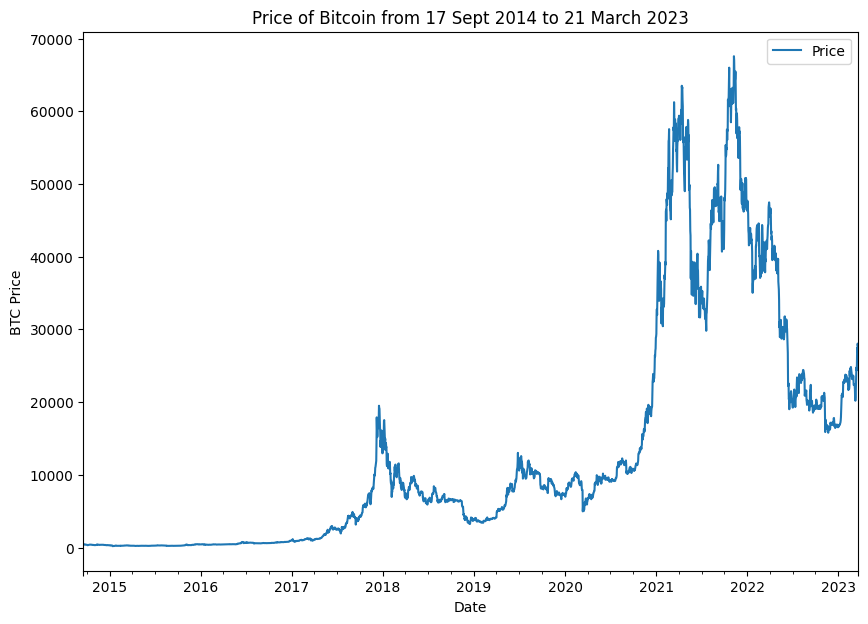

In [9]:
# let's plot everything
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

### Importing time series data with Python's CSV module

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[5])) # get the adjusted closing price

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Let's plot this

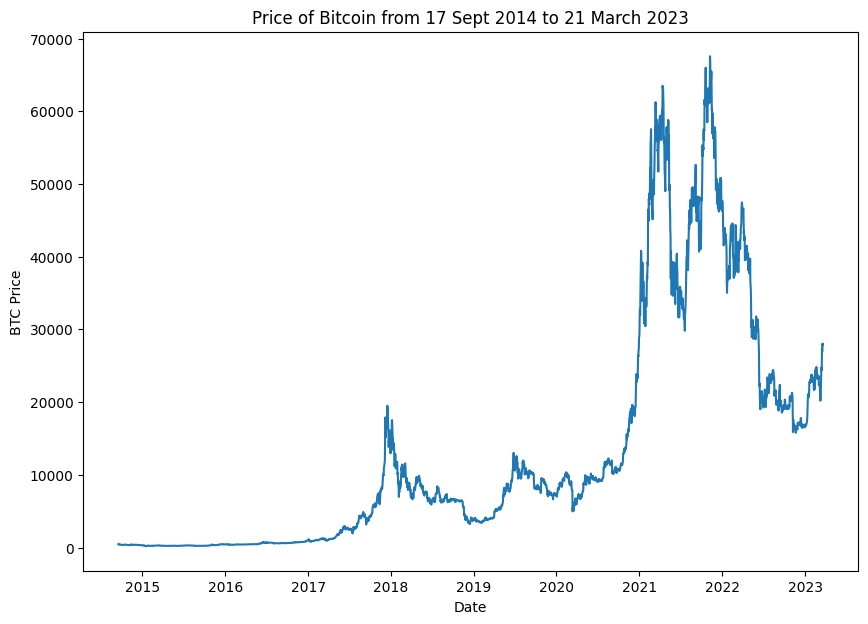

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

## Format Data Part 1 : Create train and test sets for Time Series data

Before we create splits we want to know what kind of data we have.

In time series problems, you'll either have **univariate** and **multivariate** data.

- Univariate time series data deals with one variable, for example using the price of bitcoin to predict the price of bitcoin
- Multivariate time series data deals with more than one variable, for example predicting the price of bitcoin using the price of bitcoin and block rewards and volume

### Create Train and Test sets for time series (wrong way)


In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2486,), (622,), (2486,), (622,))

Looks like the splits worked well, but let's not trust numbers on a page, visualize, visualize and visualize

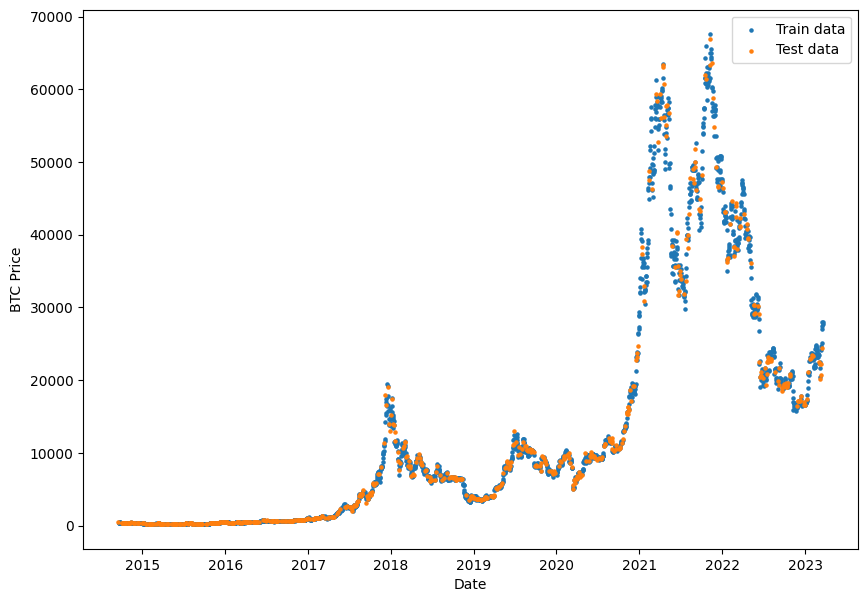

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend();

Since this is a time component so the split should be continous, if there is no time component then random split will work but since we are going to forecast the future, then we need past data.

### Create Train and Test sets for time series (the right way)

In [14]:
split_size = int(0.8 * len(prices)) # 80% of train sets and 20% of test sets

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]



Now if we visualize the plot,

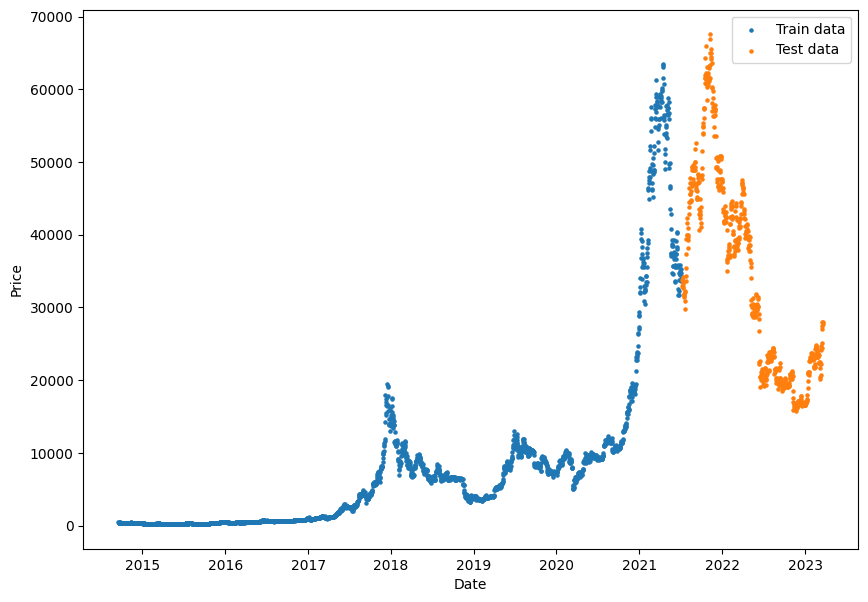

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

This is the correct way of splitting the data of time series problem. The plot should look like above.

### Creating a plotting function

Rather than retyping `matplotlib` commands to continously plot data, let's make a plotting function we can reuse later

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a time series plot on timesteps (a series of points in time) against values
  (a series of values across timesteps)

  Parameters
  ------------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

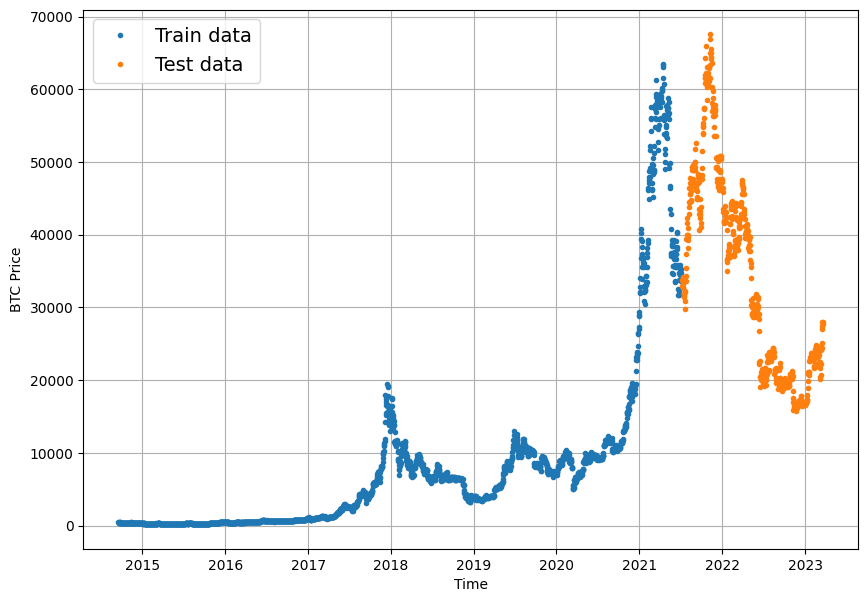

In [17]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling Experiments

There are two terms that we should be familiar with, **horizon** and **window**,
- **horizon**: number of timesteps to predict into future
- **window**: number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for Tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and window would be 7.


List of modelling experiments we are going to perform,


| **Model Number** | **Model Type** | **Horizon Size** | **Window Size** | **Extra data** |
|-------------|--------------|------------|------------|------------|
| 0 | Naive forecast (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | same as 1 (but with univariate) | 1 | 7 | Block reward size/Volume |
| 7 | [N-Beats Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0 : Naive forecast (baseline)

One of the most common baseline models for time series forecasting is naive model, (also called the naive forecast), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t`(y-hat) is equal to the value at timestep `t-1`(the previous timestep)

In an open system (like a stock market or crypto market), you'll often find beating the naive forecast with any kind of model is quite hard.

> 🔑 **Note**: an **open system** is a system where inputs and outputs can freely flow, such as market (stock or crypto), whereas a **closed system** the inputs and outputs are contained within the system (like a poker game with friends, as we know the buy in and how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [18]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:] # view first and last 10

(array([32877.371094, 33798.011719, 33520.519531, 34240.1875  ,
        33155.847656, 32702.025391, 32822.347656, 31780.730469,
        31421.539063, 31533.068359]),
 array([20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938, 25052.789063, 27423.929688, 26965.878906,
        28038.675781, 27767.236328]))

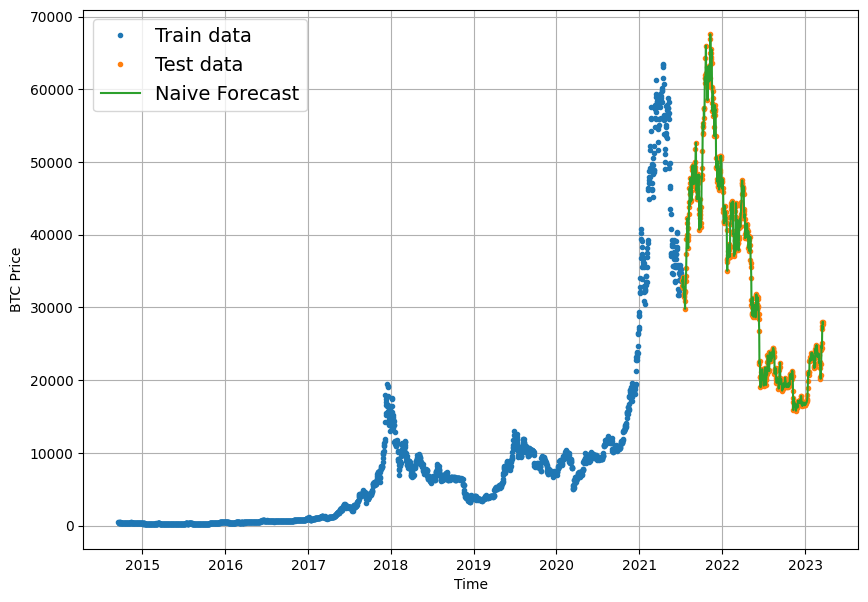

In [19]:
# plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast");

Let's zoom it and only plot the test and naive forecast


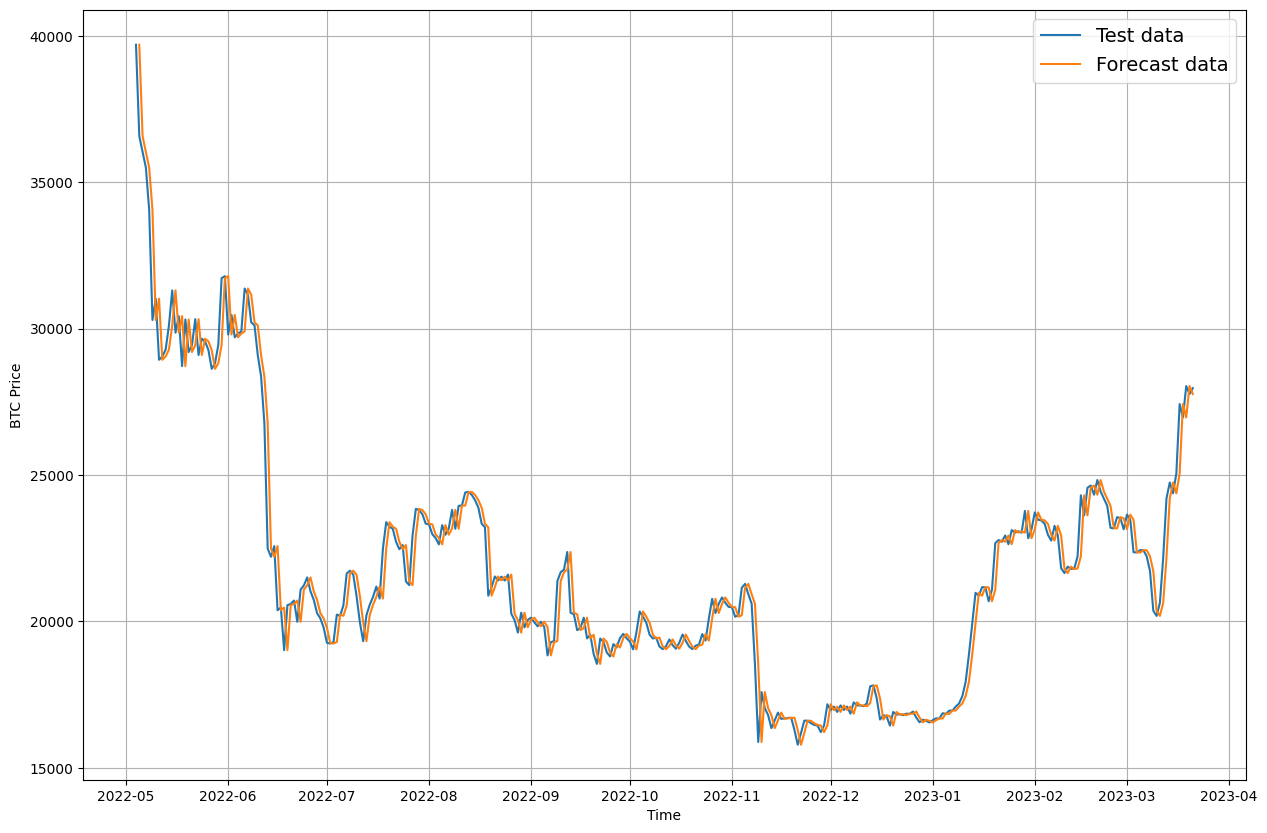

In [20]:
plt.figure(figsize=(15,10))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format="-", label="Forecast data");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a Time series model

Time series problem is often involves predicting a number which is the same output as Regression model, so we can similar types of metrics to evaluate Time series model, but let's see what are they, but thing to note for all the metrics, **lower the better** (for example an MAE of 0 is better than MAE 100).

### Scale Dependent Errors

These are metrics which can be used to compare time series values and forecasts which are in same scale.

for example, predicting the price of Bitcoin using historical prices in USD versus forecasting values in USD

| Metric | Details | Code |
| ------ |------ |------ |
| MAE (mean absolute error) |Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean squared error) | Forecasts which minimises the RMSE lead to forecasts of the mean | `tf.sqrt(tf.keras.metrics.mean_square_error())` |

### Percentage Errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used precentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| sMAPE (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions | Custom implementation |


### Scaled Errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MASE (mean absolute scaled error) | MASE equals one of the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE | See sktime's, [`mase_loss`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Creating our own MASE function

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime)(Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.
                                                                                                                          
                                                                                                                                                                                                                                                    


In [21]:
import tensorflow as tf

In [22]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

Let's put each of our different evaluation metrics together into a function.

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Alright, this will be our baseline results to beat in further modelling experiment.

So if we look into `mae` result, it's `807.27` it means that each prediction in the naive forecast is off by **$807**

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name |	Resource |
| ---- | ---- |
| Moving average |	https://machinelearningmastery.com/ moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) |	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) |	https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) |	https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) |	https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) |	https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window ?

Windowing is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example, for a univariate time series, windowing for one week (window=7) to predict the next single value(horizon=1) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Similarly the price of Bitcoin look like,

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, these are just randomly picked)

In [25]:
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# Create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset

  E.g if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we can do the same thing with entire time series data through Python loops, but to make things faster we can use [Numpy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).


Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses Numpy indexing to create a 2D of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
```
3. Uses the 2D array of multiple window steps to index on a target series.
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.




In [28]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"window_step: \n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  #print(f"Window indexes: \n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Let's try with bitcoin prices

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3101, 3101)

In [30]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987] 
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005] 
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988] 


In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [22163.949219 24197.533203 24746.074219 24375.960938 25052.789063
 27423.929688 26965.878906] -> Label: [28038.675781] 
Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328] 
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [27964.888672] 


Anyways, we have written the whole function but this can also be achieved using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

### Turning windows into Training and Test sets



In [32]:
# Make the train and test split
def make_train_test_split(windows, labels, test_split=0.2):

  split_size=int(len(windows) * (1-test_split)) # this will be default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2480, 621, 2480, 621)

In [34]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

## Creating a Model Checkpoint

For a fair comparison between all the models that we're going to build, we need to train it with equal amount of epochs let's say 100 and then store the best performing model during training so that we can compare with the best performing model.

This can be possible using `ModelCheckpoint`.

`ModelCheckpoint` callback will monitor our model's performance during training and save the best model to the file by setting `save_best_only=True`


In [35]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

We're going to start by keeping it simple, `model_1` will have:
- A single dense layer with 128 hidden units and reLu activation
- An output layer with linear activation
- Adam optimizer and MAE, MSE metrics
- Batch size of 128

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')


# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
16/20 [=======================>......] - ETA: 0s - loss: 6855.2812 - mae: 6855.2812   

20/20 [==============================] - 4s 131ms/step - loss: 5953.9575 - mae: 5953.9575 - val_loss: 1664.7501 - val_mae: 1664.7501
Epoch 2/100
20/20 [==============================] - 0s 21ms/step - loss: 952.7797 - mae: 952.7797 - val_loss: 2695.5149 - val_mae: 2695.5149
Epoch 3/100
18/20 [==========================>...] - ETA: 0s - loss: 613.3505 - mae: 613.3505

20/20 [==============================] - 2s 89ms/step - loss: 611.1298 - mae: 611.1298 - val_loss: 1611.3146 - val_mae: 1611.3146
Epoch 4/100
12/20 [=================>............] - ETA: 0s - loss: 557.2565 - mae: 557.2565

20/20 [==============================] - 2s 81ms/step - loss: 511.4079 - mae: 511.4079 - val_loss: 1570.8885 - val_mae: 1570.8885
Epoch 5/100
17/20 [========================>.....] - ETA: 0s - loss: 486.2626 - mae: 486.2626

20/20 [==============================] - 1s 74ms/step - loss: 485.7273 - mae: 485.7273 - val_loss: 1546.4520 - val_mae: 1546.4520
Epoch 6/100
15/20 [=====================>........] - ETA: 0s - loss: 487.1847 - mae: 487.1847

20/20 [==============================] - 3s 131ms/step - loss: 480.5843 - mae: 480.5843 - val_loss: 1540.4175 - val_mae: 1540.4175
Epoch 7/100
17/20 [========================>.....] - ETA: 0s - loss: 469.6415 - mae: 469.6415

20/20 [==============================] - 1s 68ms/step - loss: 468.0412 - mae: 468.0412 - val_loss: 1498.8988 - val_mae: 1498.8988
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 468.0412 - mae: 468.0412

20/20 [==============================] - 2s 83ms/step - loss: 471.1369 - mae: 471.1369 - val_loss: 1418.6805 - val_mae: 1418.6805
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 445.6767 - mae: 445.6767 - val_loss: 1432.9149 - val_mae: 1432.9149
Epoch 10/100
18/20 [==========================>...] - ETA: 0s - loss: 430.0262 - mae: 430.0262

20/20 [==============================] - 1s 51ms/step - loss: 424.7070 - mae: 424.7070 - val_loss: 1415.1125 - val_mae: 1415.1125
Epoch 11/100
15/20 [=====================>........] - ETA: 0s - loss: 404.5515 - mae: 404.5515

20/20 [==============================] - 1s 56ms/step - loss: 413.3362 - mae: 413.3362 - val_loss: 1408.1873 - val_mae: 1408.1873
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 409.5813 - mae: 409.5813 - val_loss: 1534.6877 - val_mae: 1534.6877
Epoch 13/100
12/20 [=================>............] - ETA: 0s - loss: 423.5204 - mae: 423.5204

20/20 [==============================] - 1s 62ms/step - loss: 399.4234 - mae: 399.4234 - val_loss: 1232.0435 - val_mae: 1232.0435
Epoch 14/100
19/20 [===========================>..] - ETA: 0s - loss: 379.5965 - mae: 379.5965

20/20 [==============================] - 1s 52ms/step - loss: 377.7702 - mae: 377.7702 - val_loss: 1214.3871 - val_mae: 1214.3871
Epoch 15/100
20/20 [==============================] - 0s 7ms/step - loss: 366.4476 - mae: 366.4476 - val_loss: 1499.6833 - val_mae: 1499.6833
Epoch 16/100
16/20 [=======================>......] - ETA: 0s - loss: 371.7533 - mae: 371.7533

20/20 [==============================] - 1s 53ms/step - loss: 362.1165 - mae: 362.1165 - val_loss: 1132.2876 - val_mae: 1132.2876
Epoch 17/100
20/20 [==============================] - 0s 9ms/step - loss: 347.7314 - mae: 347.7314 - val_loss: 1235.6864 - val_mae: 1235.6864
Epoch 18/100
20/20 [==============================] - ETA: 0s - loss: 346.5113 - mae: 346.5113

20/20 [==============================] - 2s 80ms/step - loss: 346.5113 - mae: 346.5113 - val_loss: 1083.9791 - val_mae: 1083.9791
Epoch 19/100
20/20 [==============================] - 0s 16ms/step - loss: 343.4210 - mae: 343.4210 - val_loss: 1252.3170 - val_mae: 1252.3170
Epoch 20/100
20/20 [==============================] - 0s 16ms/step - loss: 343.5126 - mae: 343.5126 - val_loss: 1086.7324 - val_mae: 1086.7324
Epoch 21/100
13/20 [==================>...........] - ETA: 0s - loss: 319.1062 - mae: 319.1062

20/20 [==============================] - 2s 97ms/step - loss: 307.6809 - mae: 307.6809 - val_loss: 991.3431 - val_mae: 991.3431
Epoch 22/100
18/20 [==========================>...] - ETA: 0s - loss: 300.5818 - mae: 300.5818

20/20 [==============================] - 2s 110ms/step - loss: 302.2595 - mae: 302.2595 - val_loss: 979.4347 - val_mae: 979.4347
Epoch 23/100
20/20 [==============================] - 0s 9ms/step - loss: 300.9409 - mae: 300.9409 - val_loss: 1249.1331 - val_mae: 1249.1331
Epoch 24/100
20/20 [==============================] - 0s 4ms/step - loss: 320.0003 - mae: 320.0003 - val_loss: 1066.7896 - val_mae: 1066.7896
Epoch 25/100
 1/20 [>.............................] - ETA: 0s - loss: 215.8012 - mae: 215.8012

20/20 [==============================] - 1s 53ms/step - loss: 284.9495 - mae: 284.9495 - val_loss: 974.6549 - val_mae: 974.6549
Epoch 26/100
20/20 [==============================] - 0s 9ms/step - loss: 291.5289 - mae: 291.5289 - val_loss: 1089.8889 - val_mae: 1089.8889
Epoch 27/100
20/20 [==============================] - 0s 7ms/step - loss: 300.7921 - mae: 300.7921 - val_loss: 977.7079 - val_mae: 977.7079
Epoch 28/100
17/20 [========================>.....] - ETA: 0s - loss: 275.5623 - mae: 275.5623

20/20 [==============================] - 1s 72ms/step - loss: 275.3850 - mae: 275.3850 - val_loss: 942.4528 - val_mae: 942.4528
Epoch 29/100
20/20 [==============================] - 0s 5ms/step - loss: 276.1419 - mae: 276.1419 - val_loss: 945.2155 - val_mae: 945.2155
Epoch 30/100
20/20 [==============================] - 0s 7ms/step - loss: 280.9817 - mae: 280.9817 - val_loss: 978.5695 - val_mae: 978.5695
Epoch 31/100
20/20 [==============================] - 0s 9ms/step - loss: 273.3195 - mae: 273.3195 - val_loss: 1005.4033 - val_mae: 1005.4033
Epoch 32/100
20/20 [==============================] - 0s 5ms/step - loss: 284.1886 - mae: 284.1886 - val_loss: 1017.2877 - val_mae: 1017.2877
Epoch 33/100
20/20 [==============================] - 0s 4ms/step - loss: 290.1754 - mae: 290.1754 - val_loss: 979.0425 - val_mae: 979.0425
Epoch 34/100
20/20 [==============================] - 0s 7ms/step - loss: 279.6487 - mae: 279.6487 - val_loss: 987.1151 - val_mae: 987.1151
Epoch 35/100
10/20 [========

20/20 [==============================] - 1s 64ms/step - loss: 286.6039 - mae: 286.6039 - val_loss: 906.1581 - val_mae: 906.1581
Epoch 36/100
20/20 [==============================] - 0s 10ms/step - loss: 270.7587 - mae: 270.7587 - val_loss: 1000.7747 - val_mae: 1000.7747
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 284.0118 - mae: 284.0118 - val_loss: 909.2154 - val_mae: 909.2154
Epoch 38/100
20/20 [==============================] - 0s 5ms/step - loss: 270.7558 - mae: 270.7558 - val_loss: 907.1840 - val_mae: 907.1840
Epoch 39/100
13/20 [==================>...........] - ETA: 0s - loss: 292.4887 - mae: 292.4887

20/20 [==============================] - 1s 63ms/step - loss: 282.4833 - mae: 282.4833 - val_loss: 895.5836 - val_mae: 895.5836
Epoch 40/100
20/20 [==============================] - 0s 5ms/step - loss: 300.1815 - mae: 300.1815 - val_loss: 1407.5490 - val_mae: 1407.5490
Epoch 41/100
20/20 [==============================] - 0s 5ms/step - loss: 303.6892 - mae: 303.6892 - val_loss: 1028.8265 - val_mae: 1028.8265
Epoch 42/100
19/20 [===========================>..] - ETA: 0s - loss: 281.3269 - mae: 281.3269

20/20 [==============================] - 1s 53ms/step - loss: 281.3178 - mae: 281.3178 - val_loss: 878.8979 - val_mae: 878.8979
Epoch 43/100
20/20 [==============================] - 0s 7ms/step - loss: 261.4180 - mae: 261.4180 - val_loss: 893.5592 - val_mae: 893.5592
Epoch 44/100
15/20 [=====================>........] - ETA: 0s - loss: 272.2155 - mae: 272.2155

20/20 [==============================] - 1s 52ms/step - loss: 267.8775 - mae: 267.8775 - val_loss: 876.8051 - val_mae: 876.8051
Epoch 45/100
 1/20 [>.............................] - ETA: 0s - loss: 225.1774 - mae: 225.1774

20/20 [==============================] - 1s 47ms/step - loss: 269.3759 - mae: 269.3759 - val_loss: 868.5334 - val_mae: 868.5334
Epoch 46/100
19/20 [===========================>..] - ETA: 0s - loss: 269.8392 - mae: 269.8392

20/20 [==============================] - 2s 126ms/step - loss: 269.2174 - mae: 269.2174 - val_loss: 866.0783 - val_mae: 866.0783
Epoch 47/100
20/20 [==============================] - 0s 8ms/step - loss: 263.3294 - mae: 263.3294 - val_loss: 874.4185 - val_mae: 874.4185
Epoch 48/100
20/20 [==============================] - 0s 11ms/step - loss: 258.7309 - mae: 258.7309 - val_loss: 872.0861 - val_mae: 872.0861
Epoch 49/100
20/20 [==============================] - 0s 8ms/step - loss: 263.3409 - mae: 263.3409 - val_loss: 875.3621 - val_mae: 875.3621
Epoch 50/100
 1/20 [>.............................] - ETA: 0s - loss: 367.9484 - mae: 367.9484

20/20 [==============================] - 1s 42ms/step - loss: 257.8582 - mae: 257.8582 - val_loss: 864.0532 - val_mae: 864.0532
Epoch 51/100
20/20 [==============================] - 0s 8ms/step - loss: 261.7048 - mae: 261.7048 - val_loss: 881.7874 - val_mae: 881.7874
Epoch 52/100
20/20 [==============================] - 0s 8ms/step - loss: 259.5945 - mae: 259.5945 - val_loss: 873.7529 - val_mae: 873.7529
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 261.5915 - mae: 261.5915 - val_loss: 868.6525 - val_mae: 868.6525
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 271.2723 - mae: 271.2723 - val_loss: 886.0490 - val_mae: 886.0490
Epoch 55/100
20/20 [==============================] - 0s 10ms/step - loss: 265.0632 - mae: 265.0632 - val_loss: 900.4203 - val_mae: 900.4203
Epoch 56/100
16/20 [=======================>......] - ETA: 0s - loss: 288.6985 - mae: 288.6985

20/20 [==============================] - 1s 45ms/step - loss: 275.7108 - mae: 275.7108 - val_loss: 855.2319 - val_mae: 855.2319
Epoch 57/100
20/20 [==============================] - 0s 7ms/step - loss: 272.1200 - mae: 272.1200 - val_loss: 862.6574 - val_mae: 862.6574
Epoch 58/100
20/20 [==============================] - 0s 12ms/step - loss: 257.4837 - mae: 257.4837 - val_loss: 957.3308 - val_mae: 957.3308
Epoch 59/100
20/20 [==============================] - 0s 8ms/step - loss: 260.0157 - mae: 260.0157 - val_loss: 860.8306 - val_mae: 860.8306
Epoch 60/100
11/20 [===============>..............] - ETA: 0s - loss: 276.1955 - mae: 276.1955

20/20 [==============================] - 1s 47ms/step - loss: 254.4835 - mae: 254.4835 - val_loss: 847.9277 - val_mae: 847.9277
Epoch 61/100
20/20 [==============================] - 0s 6ms/step - loss: 258.2496 - mae: 258.2496 - val_loss: 885.9482 - val_mae: 885.9482
Epoch 62/100
20/20 [==============================] - 0s 8ms/step - loss: 257.5765 - mae: 257.5765 - val_loss: 946.9471 - val_mae: 946.9471
Epoch 63/100
20/20 [==============================] - 0s 5ms/step - loss: 264.0545 - mae: 264.0545 - val_loss: 904.5315 - val_mae: 904.5315
Epoch 64/100
 1/20 [>.............................] - ETA: 0s - loss: 249.7049 - mae: 249.7049

20/20 [==============================] - 1s 44ms/step - loss: 256.2915 - mae: 256.2915 - val_loss: 845.8318 - val_mae: 845.8318
Epoch 65/100
20/20 [==============================] - 0s 7ms/step - loss: 261.7364 - mae: 261.7364 - val_loss: 956.3452 - val_mae: 956.3452
Epoch 66/100
20/20 [==============================] - 0s 7ms/step - loss: 259.6014 - mae: 259.6014 - val_loss: 854.3122 - val_mae: 854.3122
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 297.0837 - mae: 297.0837 - val_loss: 1130.3657 - val_mae: 1130.3657
Epoch 68/100
 1/20 [>.............................] - ETA: 0s - loss: 250.9969 - mae: 250.9969

20/20 [==============================] - 1s 51ms/step - loss: 258.5584 - mae: 258.5584 - val_loss: 845.4158 - val_mae: 845.4158
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 253.9522 - mae: 253.9522 - val_loss: 990.3499 - val_mae: 990.3499
Epoch 70/100
20/20 [==============================] - 0s 8ms/step - loss: 272.0092 - mae: 272.0092 - val_loss: 932.8905 - val_mae: 932.8905
Epoch 71/100
16/20 [=======================>......] - ETA: 0s - loss: 268.3408 - mae: 268.3408

20/20 [==============================] - 1s 44ms/step - loss: 264.3220 - mae: 264.3220 - val_loss: 843.3857 - val_mae: 843.3857
Epoch 72/100
20/20 [==============================] - 0s 9ms/step - loss: 264.2091 - mae: 264.2091 - val_loss: 1107.4866 - val_mae: 1107.4866
Epoch 73/100
20/20 [==============================] - 0s 7ms/step - loss: 283.2833 - mae: 283.2833 - val_loss: 952.0642 - val_mae: 952.0642
Epoch 74/100
20/20 [==============================] - 0s 4ms/step - loss: 257.0650 - mae: 257.0650 - val_loss: 905.3831 - val_mae: 905.3831
Epoch 75/100
20/20 [==============================] - 0s 5ms/step - loss: 265.9041 - mae: 265.9041 - val_loss: 868.6616 - val_mae: 868.6616
Epoch 76/100
16/20 [=======================>......] - ETA: 0s - loss: 245.1551 - mae: 245.1551

20/20 [==============================] - 1s 49ms/step - loss: 254.0551 - mae: 254.0551 - val_loss: 839.0715 - val_mae: 839.0715
Epoch 77/100
20/20 [==============================] - 0s 5ms/step - loss: 263.2199 - mae: 263.2199 - val_loss: 951.9323 - val_mae: 951.9323
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 277.5272 - mae: 277.5272 - val_loss: 842.7245 - val_mae: 842.7245
Epoch 79/100
20/20 [==============================] - 0s 6ms/step - loss: 252.3341 - mae: 252.3341 - val_loss: 840.4225 - val_mae: 840.4225
Epoch 80/100
20/20 [==============================] - 0s 6ms/step - loss: 265.9913 - mae: 265.9913 - val_loss: 925.1135 - val_mae: 925.1135
Epoch 81/100
20/20 [==============================] - 0s 5ms/step - loss: 264.3294 - mae: 264.3294 - val_loss: 859.3016 - val_mae: 859.3016
Epoch 82/100
20/20 [==============================] - 0s 6ms/step - loss: 263.5752 - mae: 263.5752 - val_loss: 1093.5482 - val_mae: 1093.5482
Epoch 83/100
20/20 [==========

20/20 [==============================] - 2s 79ms/step - loss: 257.2355 - mae: 257.2355 - val_loss: 835.1205 - val_mae: 835.1205
Epoch 90/100
20/20 [==============================] - 0s 11ms/step - loss: 250.5125 - mae: 250.5125 - val_loss: 903.7134 - val_mae: 903.7134
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 251.5526 - mae: 251.5526 - val_loss: 873.4280 - val_mae: 873.4280
Epoch 92/100
20/20 [==============================] - 0s 5ms/step - loss: 254.8365 - mae: 254.8365 - val_loss: 837.7173 - val_mae: 837.7173
Epoch 93/100
20/20 [==============================] - 0s 7ms/step - loss: 257.3741 - mae: 257.3741 - val_loss: 838.0466 - val_mae: 838.0466
Epoch 94/100
20/20 [==============================] - 0s 7ms/step - loss: 251.3163 - mae: 251.3163 - val_loss: 1046.3134 - val_mae: 1046.3134
Epoch 95/100
20/20 [==============================] - 0s 9ms/step - loss: 283.6741 - mae: 283.6741 - val_loss: 967.8206 - val_mae: 967.8206
Epoch 96/100
20/20 [=========

20/20 [==============================] - 1s 51ms/step - loss: 254.2755 - mae: 254.2755 - val_loss: 833.2970 - val_mae: 833.2970


In [37]:
# evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 5ms/step - loss: 833.2970 - mae: 833.2970


[833.2969970703125, 833.2969970703125]

This is the last epoch's evaluation results, but let's check the best model weights

In [38]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 833.2970 - mae: 833.2970


[833.2969970703125, 833.2969970703125]

Okay, not bad but what about the predictions on `model_1`. Let's create a function to make predictions and then evaluate the results of model_1 on those predictions.

### Make Prediction function

In [39]:
def make_predictions(model, input_data):
  """
  Returns the prediction result on input_data for the model passed.
  """
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds) # returns 1D array of predictions

In [40]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([32816.074, 33462.625, 33518.098, 33960.51 , 33307.97 , 32618.096,
       32703.49 , 31788.998, 31221.79 , 31366.332], dtype=float32)>

In [41]:
test_labels.shape, model_1_preds.shape

((621, 1), TensorShape([621]))

In [42]:
# evaluate results
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 833.2969,
 'mse': 1543701.0,
 'rmse': 1242.4576,
 'mape': 2.4049375,
 'mase': 1.0000142}

In [43]:
# view the naive results
naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Naive model results (baseline) is beating our first dense model(model_1) but that's expected. Let's do further visualization by plotting the prediction in the graph.

### Plot `model_1` results

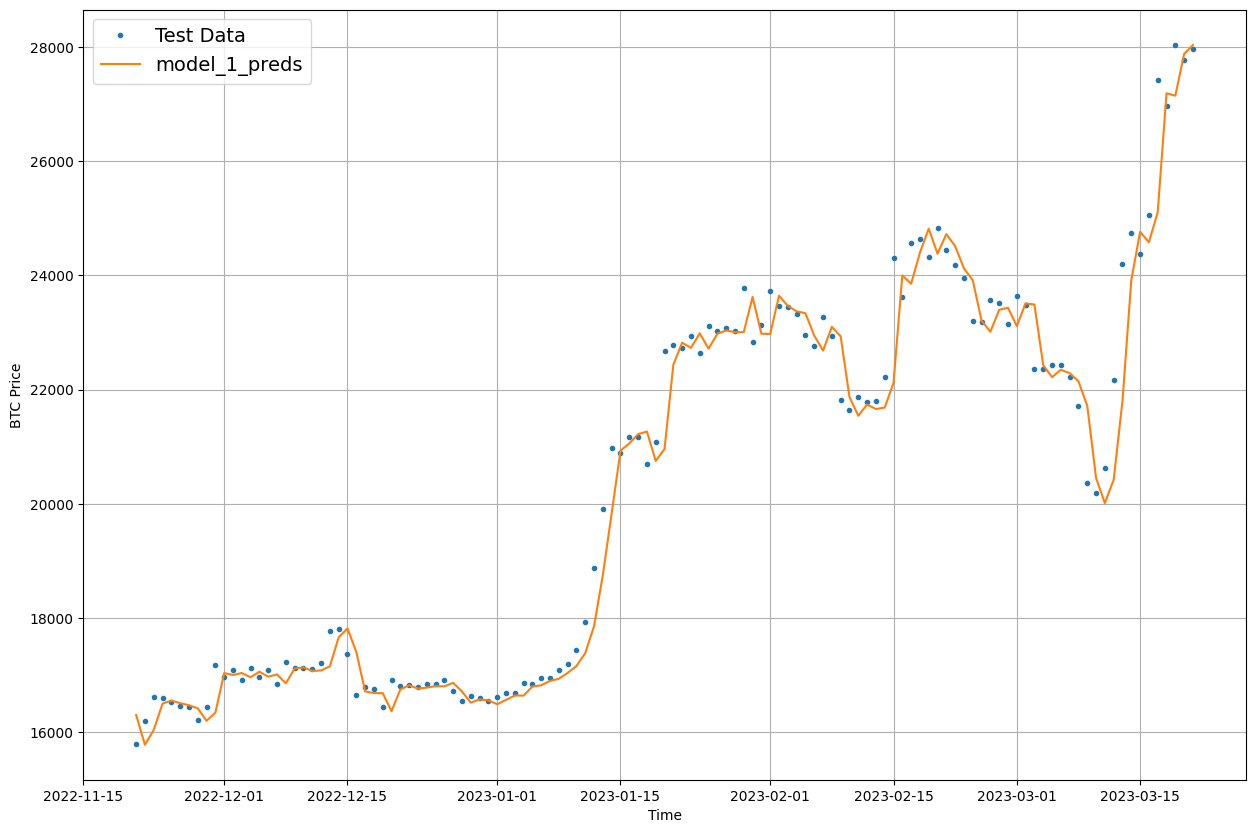

In [44]:
offset = 500
plt.figure(figsize=(15, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-",label="model_1_preds")

Something wrong with the predictions ? 

And also predictions are little behind the actual values. For more about this, [Read Autocorrelation](https://otexts.com/fpp3/acf.html)

Since they're on the test dataset. So they're not actual forecasts that we are trying for predicting a price.

With our current model setup, we've to make forecasts for the future.

## Model 2: Dense (window=30, horizon=1)

In this model we are going to predict on window_size 30, that is past 30 days of bitcoin prices to predict next day of bitcoin price.

In [45]:
HORIZON=1
WINDOW_SIZE=30

In [46]:
# Reset the windows and labels with 30 day prices of bitcoin
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:2], full_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996],
        [391.441986]]))

In [47]:
# Create train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2462, 616, 2462, 616)

In [48]:
# Now ready to create our dense model

tf.random.set_seed(17)

# Create the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], 'model_2_dense')

# compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [49]:
# evaluate the model with the last epochs 
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1300.1431


1300.14306640625

In [50]:
# Evaluation on the best model
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 917.8951


917.8950805664062

In [51]:
# prediction on model_2
model_2_preds = make_predictions(model_2, test_windows)

# evaluate the results
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

20/20 [==============================] - 0s 1ms/step


{'mae': 917.8951,
 'mse': 1859660.9,
 'rmse': 1363.6938,
 'mape': 2.6509519,
 'mase': 0.99996686}

In [52]:
model_1_results

{'mae': 833.2969,
 'mse': 1543701.0,
 'rmse': 1242.4576,
 'mape': 2.4049375,
 'mase': 1.0000142}

It looks like `model_1` performs better than `model_2`.

Also, smaller windows size is performing better so in that case we can create window size of something like 5 days.



How do the predictions look ?

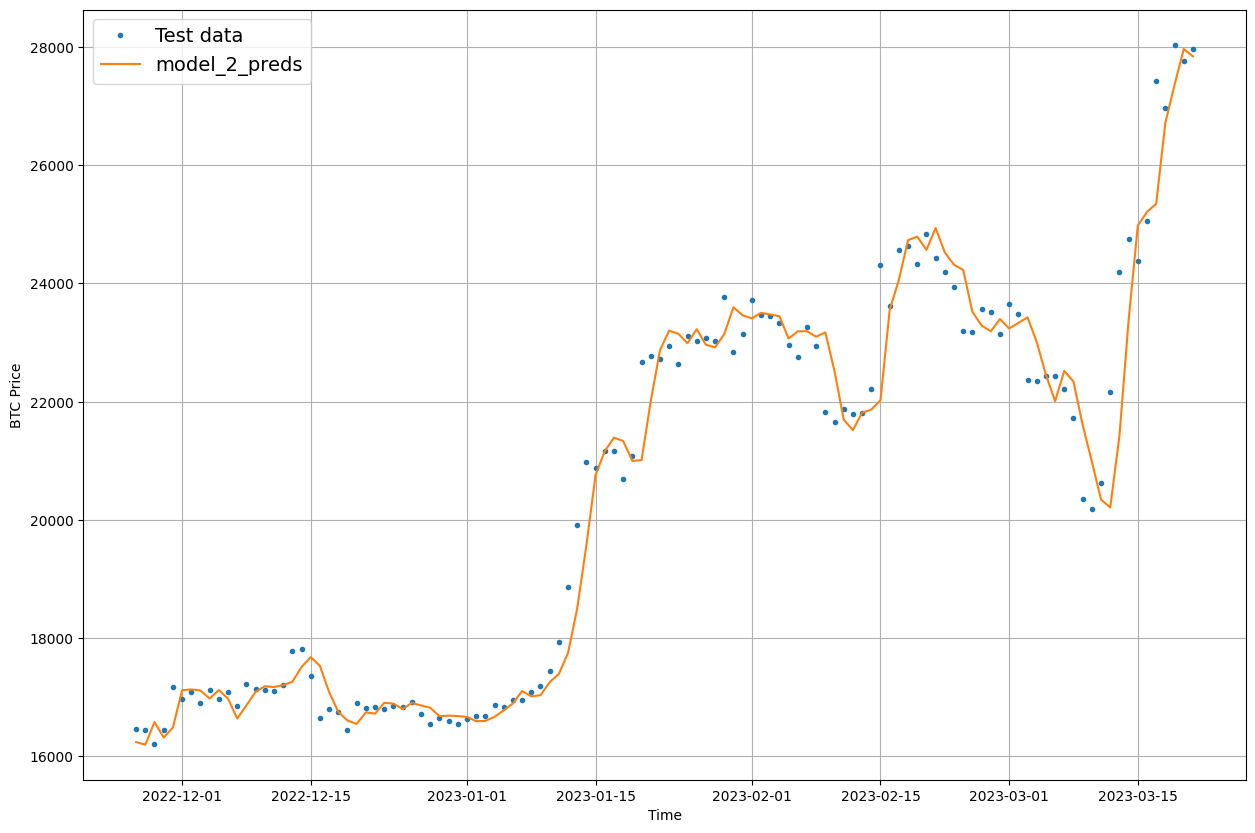

In [53]:
offset = 500
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3 : Dense(window=30, horizon=7)

In [54]:
HORIZON=7
WINDOW_SIZE=30

# create windows and labels
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
         383.15799 , 358.416992],
        [391.441986, 389.54599 , 382.845001, 386.475006, 383.1579

In [55]:
len(train_windows), len(test_windows)

(2457, 615)

In [56]:
tf.random.set_seed(17)

# Create Model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
# evaluation on last epoch
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 5ms/step - loss: 1801.1177


1801.11767578125

In [58]:
# load the best model and evaluate
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 1735.5352


1735.53515625

This is going to be large because we are trying to predict 7 days in advance, for example we want to predict the weather in advance of 7 days. So there will be higher chances of wrong predictibility.

In [59]:
# Make prediction and see the results
model_3_preds = make_predictions(model_3, test_windows)

20/20 [==============================] - 0s 2ms/step


In [60]:
model_3_preds.shape, test_labels.shape

(TensorShape([615, 7]), (615, 7))

In [61]:
# view the results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': array([ 552.7104 ,  771.82117, 1043.212  , 2356.2993 , 1296.7001 ,
        1065.1537 , 1070.7704 ,  875.99524,  958.79266, 1132.1049 ,
        1560.1482 , 3225.758  , 4512.2065 , 4503.032  , 5047.656  ,
        5414.0557 , 5284.645  , 4548.922  , 3669.4202 , 1472.077  ,
         975.0586 , 1015.68304, 1873.2014 , 2214.9167 , 2037.0223 ,
        3084.6333 , 4718.594  , 4913.944  , 4471.268  , 2982.5637 ,
        1743.4861 , 1769.596  , 1175.2834 , 1119.058  , 1241.495  ,
        1537.1456 , 1338.4436 , 1708.4258 , 1828.7567 , 2151.5278 ,
        2618.202  , 3255.6624 , 2685.9614 , 1196.7305 , 1738.3772 ,
        1832.5564 , 1904.3594 ,  915.9665 ,  868.87665, 1618.5391 ,
         782.9576 ,  971.33875, 1292.9353 , 2058.861  , 2627.6667 ,
        2293.4683 , 2611.9167 , 3506.7283 , 4059.5881 , 5030.149  ,
        7191.302  , 3182.5464 , 1268.9102 , 1218.26   , 1502.2784 ,
        2264.8738 , 1543.5184 , 2352.1965 , 1959.5709 , 2602.3494 ,
        3188.8333 , 3982.1575 , 4530.1797

This is multi-dimensional output because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this we need to adjust our `evaluate_preds()` function.

In [62]:
tf.reduce_mean(model_3_results['mae'])

<tf.Tensor: shape=(), dtype=float32, numpy=1735.5352>

In [63]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # If horizon is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Let's evaulate our `model_3` now

In [64]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1735.5352,
 'mse': 6447505.5,
 'rmse': 2003.4187,
 'mape': 5.1187305,
 'mase': 0.99998134}

In [65]:
model_2_results

{'mae': 917.8951,
 'mse': 1859660.9,
 'rmse': 1363.6938,
 'mape': 2.6509519,
 'mase': 0.99996686}

`model_3` seems even worse compared to previous modelling experiments. Let's plot the predictions.

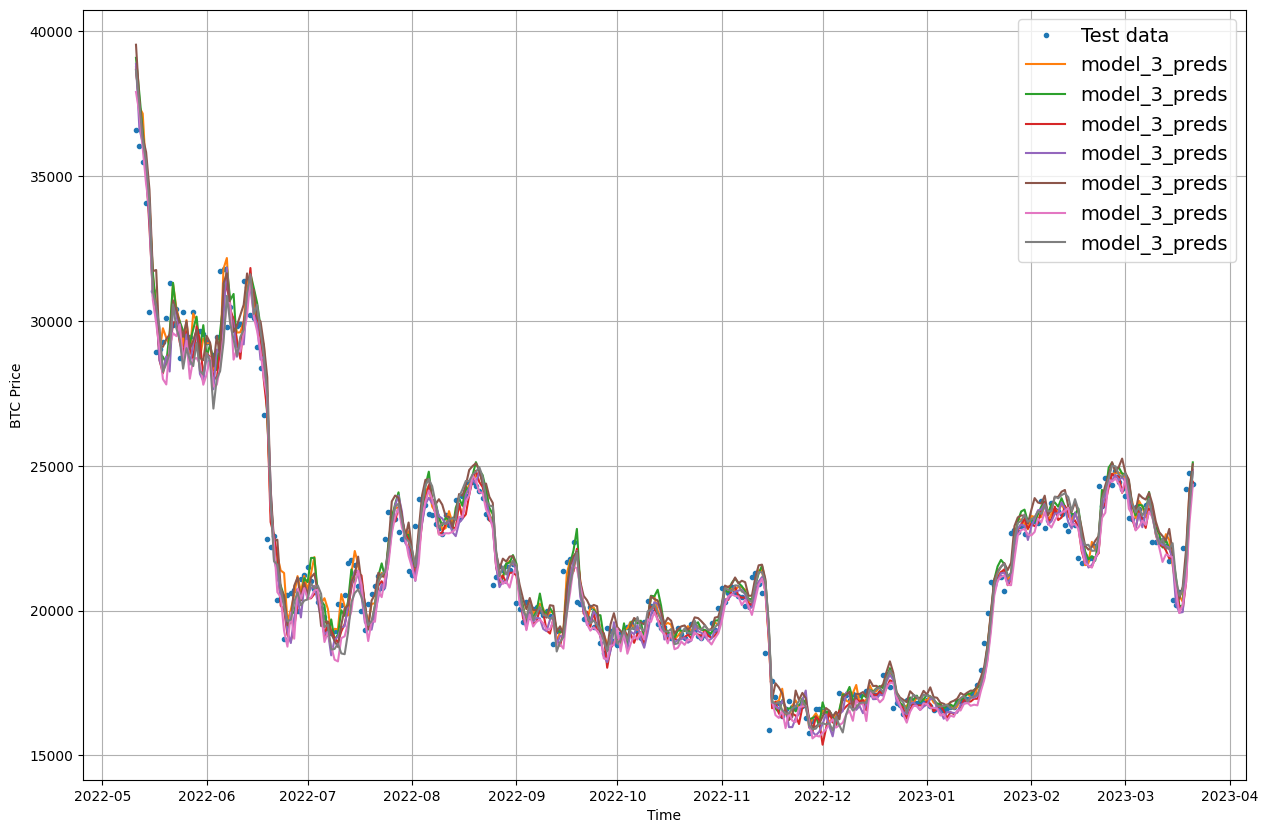

In [66]:
offset=300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,start=offset,format="-", label="model_3_preds")

Since our predictions were multi-dimensional, the plot predictions also look like stacked every timesteps together.

Let's fix this by aggregating our model's predictions.

**Note**: Aggregating the results of the predictions lead to lose in information from it's original predictions because it was originally predicted for 7 days but if we aggregate it in 1 day then it'll lose the detailed predictions.

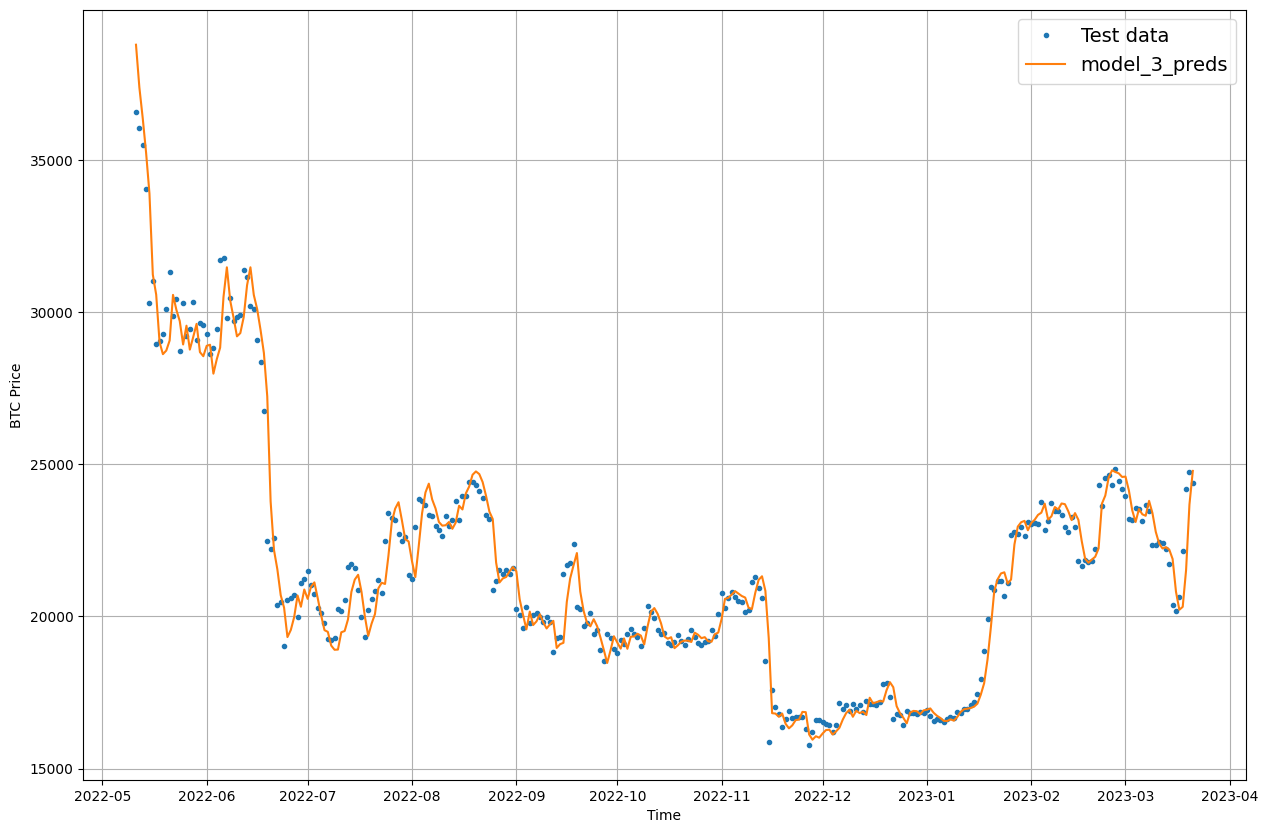

In [67]:
offset = 300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-" ,label="model_3_preds")

## Which of our model is performing best so far ?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naive model to see which model is performing the best so far.

<Axes: >

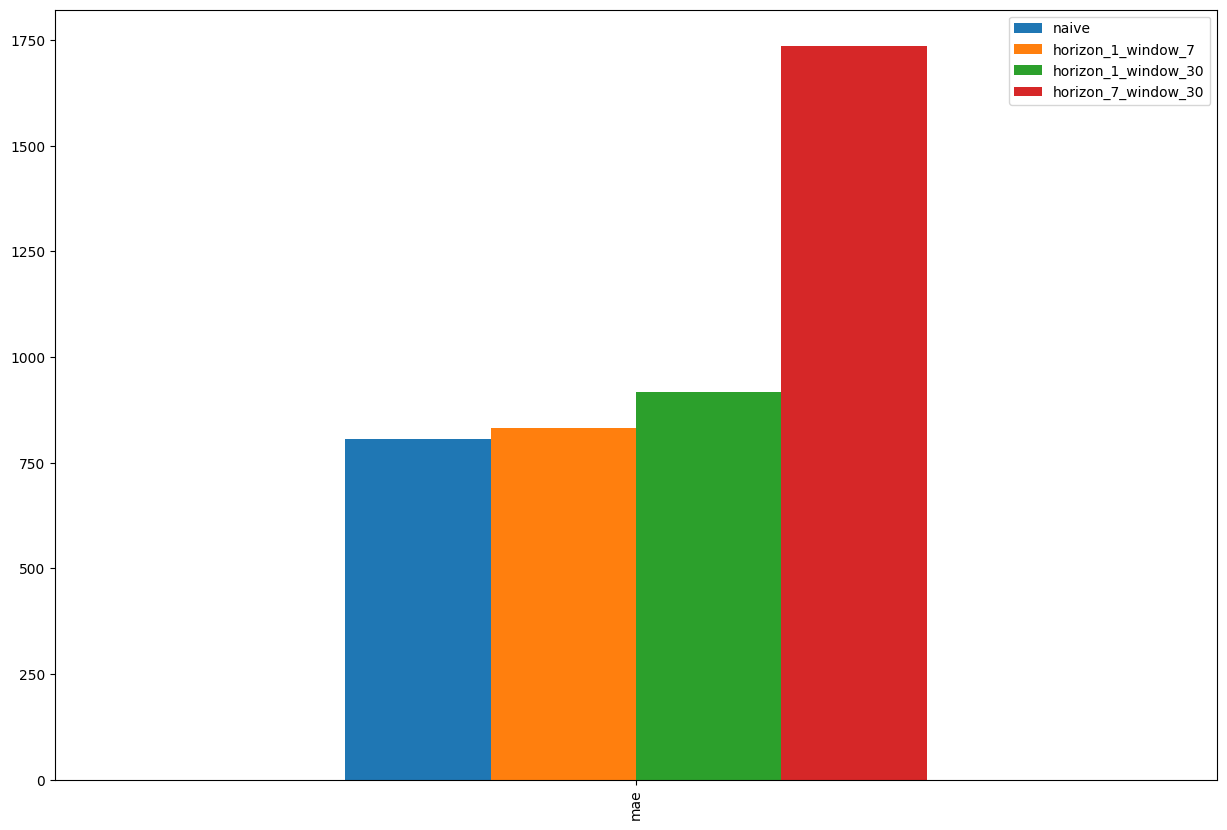

In [68]:
pd.DataFrame({"naive":naive_results['mae'],
              "horizon_1_window_7":model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=["mae"]).plot(kind='bar', figsize=(15,10))

Naive model is hard to beat in an open system, but `model_1` with HORIZON 1 and WINDOW SIZE 7 looks to be performing closest. So let's continue our experiments with only these set of horizon and window size.

💡 **Resource**: Due to autocorrelation in the time series data, naive model often performs best because the value of `t` will be closer to `t-1`. Today's value is probably pretty close to yesterday's value. This isn't always the case but when it is, a naive model will often get fairly good results.

Some more about how autocorrelation influences a model's predictions, [How (not) to use Machine learning for Time series forecasting : Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)

## Model 4 : Conv1D

We'll be using Conv1D model as it can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is many to one problem).

In [69]:
HORIZON=1
WINDOW_SIZE=7

In [70]:
# make windows for Conv1D model
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2480, 2480, 621, 621)

In [71]:
# let's see how our training data looks like
train_windows[0]

array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])

In [72]:
# convert into tensors
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

Alright, it says the shape is 7 which is the window size. But if we see the doc of [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to convert the shape of inputs into `batch size + (timesteps, input_dim)`

In [73]:
# check the shape
x.shape

TensorShape([7])

We need to convert this into (7,1). Let's create a expand dim layer to convert the inputs shape inside the layer.

In [74]:
expand_dim_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [75]:
# Test it with the x 
expand_dim_layer(x)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[457.334],
       [424.44 ],
       [394.796],
       [408.904],
       [398.821],
       [402.152],
       [435.791]], dtype=float32)>

In [76]:
# Create the model

tf.random.set_seed(17)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
14/20 [====================>.........] - ETA: 0s - loss: 3410.4321 

20/20 [==============================] - 3s 100ms/step - loss: 2681.0076 - val_loss: 4551.8062
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 1133.4653

20/20 [==============================] - 1s 48ms/step - loss: 592.4989 - val_loss: 1389.6998
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 395.5346

20/20 [==============================] - 1s 45ms/step - loss: 429.4347 - val_loss: 1322.9381
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 410.8741 - val_loss: 1477.3579
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 429.0518

20/20 [==============================] - 1s 63ms/step - loss: 411.7845 - val_loss: 1295.2031
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 401.2440 - val_loss: 1341.0515
Epoch 7/100
15/20 [=====================>........] - ETA: 0s - loss: 404.1344

20/20 [==============================] - 1s 63ms/step - loss: 397.1795 - val_loss: 1281.7535
Epoch 8/100
 1/20 [>.............................] - ETA: 0s - loss: 414.0415

20/20 [==============================] - 2s 81ms/step - loss: 415.0498 - val_loss: 1276.8735
Epoch 9/100
17/20 [========================>.....] - ETA: 0s - loss: 381.0470

20/20 [==============================] - 2s 96ms/step - loss: 390.7434 - val_loss: 1222.0486
Epoch 10/100
20/20 [==============================] - 0s 8ms/step - loss: 379.3511 - val_loss: 1263.3931
Epoch 11/100
20/20 [==============================] - 0s 6ms/step - loss: 376.4762 - val_loss: 1286.2668
Epoch 12/100
20/20 [==============================] - 0s 4ms/step - loss: 382.2548 - val_loss: 1294.0967
Epoch 13/100
 1/20 [>.............................] - ETA: 0s - loss: 464.9082

20/20 [==============================] - 1s 64ms/step - loss: 370.8227 - val_loss: 1152.0590
Epoch 14/100
20/20 [==============================] - 0s 4ms/step - loss: 354.8725 - val_loss: 1260.2053
Epoch 15/100
20/20 [==============================] - 0s 5ms/step - loss: 352.6691 - val_loss: 1296.3062
Epoch 16/100
15/20 [=====================>........] - ETA: 0s - loss: 358.4320

20/20 [==============================] - 1s 66ms/step - loss: 348.3690 - val_loss: 1102.2937
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 341.4325 - val_loss: 1249.8680
Epoch 18/100
13/20 [==================>...........] - ETA: 0s - loss: 354.3806

20/20 [==============================] - 2s 84ms/step - loss: 341.3615 - val_loss: 1072.0532
Epoch 19/100
20/20 [==============================] - 0s 8ms/step - loss: 335.3097 - val_loss: 1126.5272
Epoch 20/100
20/20 [==============================] - 0s 9ms/step - loss: 337.1570 - val_loss: 1118.8621
Epoch 21/100
20/20 [==============================] - 0s 8ms/step - loss: 321.5972 - val_loss: 1087.2170
Epoch 22/100
20/20 [==============================] - 0s 6ms/step - loss: 319.6160 - val_loss: 1092.5173
Epoch 23/100
20/20 [==============================] - 0s 9ms/step - loss: 325.8267 - val_loss: 1191.1533
Epoch 24/100
 8/20 [===========>..................] - ETA: 0s - loss: 348.4258

20/20 [==============================] - 2s 79ms/step - loss: 339.6530 - val_loss: 1014.6498
Epoch 25/100
13/20 [==================>...........] - ETA: 0s - loss: 322.4070

20/20 [==============================] - 3s 136ms/step - loss: 311.1155 - val_loss: 989.3387
Epoch 26/100
20/20 [==============================] - 0s 14ms/step - loss: 306.8289 - val_loss: 1052.9329
Epoch 27/100
19/20 [===========================>..] - ETA: 0s - loss: 305.6087

20/20 [==============================] - 3s 147ms/step - loss: 306.0610 - val_loss: 980.0994
Epoch 28/100
18/20 [==========================>...] - ETA: 0s - loss: 294.7024

20/20 [==============================] - 4s 206ms/step - loss: 298.5753 - val_loss: 978.0179
Epoch 29/100
 1/20 [>.............................] - ETA: 0s - loss: 310.1713

20/20 [==============================] - 1s 66ms/step - loss: 291.6231 - val_loss: 969.0020
Epoch 30/100
16/20 [=======================>......] - ETA: 0s - loss: 297.0395

20/20 [==============================] - 1s 74ms/step - loss: 291.6846 - val_loss: 948.8140
Epoch 31/100
20/20 [==============================] - 0s 8ms/step - loss: 289.6153 - val_loss: 1031.9333
Epoch 32/100
20/20 [==============================] - 0s 8ms/step - loss: 298.3326 - val_loss: 964.8447
Epoch 33/100
20/20 [==============================] - 0s 7ms/step - loss: 317.2404 - val_loss: 1194.8827
Epoch 34/100
 1/20 [>.............................] - ETA: 0s - loss: 278.6587

20/20 [==============================] - 3s 138ms/step - loss: 295.3452 - val_loss: 939.2163
Epoch 35/100
19/20 [===========================>..] - ETA: 0s - loss: 285.3788

20/20 [==============================] - 2s 82ms/step - loss: 284.8178 - val_loss: 933.4518
Epoch 36/100
20/20 [==============================] - 0s 6ms/step - loss: 282.5583 - val_loss: 971.6288
Epoch 37/100
20/20 [==============================] - 0s 5ms/step - loss: 287.7537 - val_loss: 977.5822
Epoch 38/100
 1/20 [>.............................] - ETA: 0s - loss: 214.0414

20/20 [==============================] - 2s 86ms/step - loss: 285.9926 - val_loss: 916.4609
Epoch 39/100
20/20 [==============================] - 0s 16ms/step - loss: 292.8706 - val_loss: 1091.8661
Epoch 40/100
20/20 [==============================] - 0s 10ms/step - loss: 298.5675 - val_loss: 1063.8871
Epoch 41/100
20/20 [==============================] - 0s 8ms/step - loss: 305.4953 - val_loss: 1080.2102
Epoch 42/100
20/20 [==============================] - 0s 11ms/step - loss: 281.4893 - val_loss: 1003.5452
Epoch 43/100
20/20 [==============================] - 0s 6ms/step - loss: 281.9201 - val_loss: 983.1867
Epoch 44/100
20/20 [==============================] - 0s 13ms/step - loss: 293.9344 - val_loss: 1101.0699
Epoch 45/100
20/20 [==============================] - ETA: 0s - loss: 287.1910

20/20 [==============================] - 2s 80ms/step - loss: 287.1910 - val_loss: 900.0340
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 291.8709 - val_loss: 913.2693
Epoch 47/100
12/20 [=================>............] - ETA: 0s - loss: 269.4882

20/20 [==============================] - 2s 80ms/step - loss: 272.3753 - val_loss: 896.3224
Epoch 48/100
20/20 [==============================] - 0s 7ms/step - loss: 270.5469 - val_loss: 897.3693
Epoch 49/100
20/20 [==============================] - 0s 5ms/step - loss: 269.6634 - val_loss: 902.5758
Epoch 50/100
20/20 [==============================] - 0s 5ms/step - loss: 268.7094 - val_loss: 899.0436
Epoch 51/100
20/20 [==============================] - 0s 8ms/step - loss: 267.1039 - val_loss: 928.5052
Epoch 52/100
 1/20 [>.............................] - ETA: 0s - loss: 272.9804

20/20 [==============================] - 1s 67ms/step - loss: 267.1235 - val_loss: 891.8354
Epoch 53/100
20/20 [==============================] - 0s 16ms/step - loss: 278.4435 - val_loss: 955.0738
Epoch 54/100
20/20 [==============================] - 0s 13ms/step - loss: 284.5558 - val_loss: 952.0248
Epoch 55/100
20/20 [==============================] - 0s 10ms/step - loss: 267.4405 - val_loss: 1093.3898
Epoch 56/100
20/20 [==============================] - 0s 13ms/step - loss: 284.3437 - val_loss: 913.2516
Epoch 57/100
19/20 [===========================>..] - ETA: 0s - loss: 263.8375

20/20 [==============================] - 2s 111ms/step - loss: 265.9516 - val_loss: 880.9574
Epoch 58/100
20/20 [==============================] - 0s 7ms/step - loss: 271.0103 - val_loss: 953.2859
Epoch 59/100
20/20 [==============================] - 0s 9ms/step - loss: 270.6363 - val_loss: 923.3984
Epoch 60/100
20/20 [==============================] - 0s 10ms/step - loss: 262.6962 - val_loss: 886.8012
Epoch 61/100
20/20 [==============================] - 0s 8ms/step - loss: 263.9599 - val_loss: 931.2992
Epoch 62/100
20/20 [==============================] - 0s 8ms/step - loss: 265.5799 - val_loss: 911.8525
Epoch 63/100
10/20 [==============>...............] - ETA: 0s - loss: 267.7894

20/20 [==============================] - 1s 74ms/step - loss: 270.8614 - val_loss: 866.2715
Epoch 64/100
20/20 [==============================] - 0s 10ms/step - loss: 285.2735 - val_loss: 910.1088
Epoch 65/100
20/20 [==============================] - 0s 16ms/step - loss: 261.8108 - val_loss: 905.9545
Epoch 66/100
20/20 [==============================] - 0s 6ms/step - loss: 290.9308 - val_loss: 1303.8326
Epoch 67/100
20/20 [==============================] - 0s 12ms/step - loss: 290.0307 - val_loss: 886.3127
Epoch 68/100
20/20 [==============================] - 0s 8ms/step - loss: 264.8377 - val_loss: 945.7072
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 263.1916 - val_loss: 1034.6030
Epoch 70/100
20/20 [==============================] - 0s 12ms/step - loss: 279.4980 - val_loss: 1023.7751
Epoch 71/100
20/20 [==============================] - 0s 16ms/step - loss: 270.4373 - val_loss: 905.7413
Epoch 72/100
20/20 [==============================] - 0s 13ms/step -

20/20 [==============================] - 3s 145ms/step - loss: 269.6968 - val_loss: 853.1126
Epoch 74/100
20/20 [==============================] - 0s 13ms/step - loss: 258.1463 - val_loss: 869.5189
Epoch 75/100
20/20 [==============================] - 0s 13ms/step - loss: 263.5021 - val_loss: 879.5721
Epoch 76/100
20/20 [==============================] - 0s 5ms/step - loss: 271.4573 - val_loss: 871.8135
Epoch 77/100
20/20 [==============================] - 0s 5ms/step - loss: 272.7495 - val_loss: 888.5200
Epoch 78/100
20/20 [==============================] - 0s 5ms/step - loss: 264.4915 - val_loss: 892.1862
Epoch 79/100
 1/20 [>.............................] - ETA: 0s - loss: 267.8562

20/20 [==============================] - 1s 48ms/step - loss: 258.8221 - val_loss: 847.0507
Epoch 80/100
20/20 [==============================] - 0s 5ms/step - loss: 260.2069 - val_loss: 906.7079
Epoch 81/100
20/20 [==============================] - 0s 4ms/step - loss: 259.9051 - val_loss: 847.8110
Epoch 82/100
20/20 [==============================] - 0s 5ms/step - loss: 259.1736 - val_loss: 1002.8043
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 275.8532 - val_loss: 982.5179
Epoch 84/100
20/20 [==============================] - 0s 5ms/step - loss: 303.2343 - val_loss: 985.2719
Epoch 85/100
 1/20 [>.............................] - ETA: 0s - loss: 257.4089

20/20 [==============================] - 1s 67ms/step - loss: 276.7216 - val_loss: 842.7263
Epoch 86/100
20/20 [==============================] - 0s 8ms/step - loss: 255.3252 - val_loss: 852.3255
Epoch 87/100
20/20 [==============================] - 0s 10ms/step - loss: 256.2923 - val_loss: 863.4326
Epoch 88/100
20/20 [==============================] - 0s 7ms/step - loss: 252.7765 - val_loss: 891.1683
Epoch 89/100
20/20 [==============================] - 0s 13ms/step - loss: 267.8217 - val_loss: 855.1256
Epoch 90/100
20/20 [==============================] - 0s 7ms/step - loss: 257.6338 - val_loss: 986.4785
Epoch 91/100
20/20 [==============================] - 0s 7ms/step - loss: 258.2521 - val_loss: 860.6298
Epoch 92/100
20/20 [==============================] - 0s 6ms/step - loss: 259.1811 - val_loss: 965.4164
Epoch 93/100
20/20 [==============================] - 0s 6ms/step - loss: 257.5399 - val_loss: 859.4296
Epoch 94/100
20/20 [==============================] - 0s 8ms/step - loss: 

20/20 [==============================] - 2s 82ms/step - loss: 287.9367 - val_loss: 835.1987
Epoch 96/100
20/20 [==============================] - 0s 7ms/step - loss: 252.3174 - val_loss: 872.1676
Epoch 97/100
20/20 [==============================] - 0s 8ms/step - loss: 264.3019 - val_loss: 877.7987
Epoch 98/100
20/20 [==============================] - 0s 8ms/step - loss: 253.6808 - val_loss: 839.9615
Epoch 99/100
20/20 [==============================] - 0s 7ms/step - loss: 259.8638 - val_loss: 865.4035
Epoch 100/100
20/20 [==============================] - 0s 8ms/step - loss: 260.2600 - val_loss: 905.0156


In [77]:
# check the summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [78]:
# evaluate on the last epochs model
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 905.0157


905.0156860351562

In [79]:
# load the best model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 835.1989


835.1988525390625

In [80]:
# make some predictions
model_4_preds = make_predictions(model_4, test_windows)

# evaluate the results
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                   y_pred=model_4_preds)

model_4_results

20/20 [==============================] - 0s 3ms/step


{'mae': 835.1987,
 'mse': 1568734.4,
 'rmse': 1252.4912,
 'mape': 2.4230464,
 'mase': 1.0000142}

In [81]:
model_1_results

{'mae': 833.2969,
 'mse': 1543701.0,
 'rmse': 1242.4576,
 'mape': 2.4049375,
 'mase': 1.0000142}

Close enough with `model_1` but not better than it. Let's continue our experiments.

## Model 5 : RNN (LSTM)

We can also use a recurrent neural network to model our sequential time series data.

We're not going to change the data, the data will be same just the model architecture would be different.

In [82]:
tf.random.set_seed(17)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output, name="model_5_LSTM")

# compile the model
model_5.compile(loss='mae',
                optimizer='Adam')

# fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

In [83]:
# check the summary
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            69632     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 205,377
Trainable params: 205,377
Non-tr

In [84]:
# evaluate on last epoch
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 5ms/step - loss: 908.4256


908.4255981445312

In [85]:
# load the best model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

20/20 [==============================] - 1s 4ms/step - loss: 860.4874


860.4874267578125

In [86]:
# make predictions and check pred results
model_5_preds = make_predictions(model_5, test_windows)

model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)

model_5_results

20/20 [==============================] - 1s 6ms/step


{'mae': 860.4874,
 'mse': 1625415.4,
 'rmse': 1274.9178,
 'mape': 2.4990258,
 'mase': 1.0000142}

## Make a Multivariate time series

So far all our models predicted on univariate time series data which is only Bitcoin prices, but what are other features that may impact the price of bitcoin, that's the thing to explore.


What about the Volume ? Or Block Reward ? Could be a tweet from a famous personality like Elon Musk can fluctuate the prices. 

According to the data we have, we can use Volume and Block Reward. Then let's add these two features into our time series dataset.

In [87]:
# view the dataset
bitcoin_prices.tail()

,Price
Date,
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781
2023-03-20,27767.236328
2023-03-21,27964.888672


According to the [CMC Markets](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving) block reward events, we can assign the block reward to specific date range in our dataset.

| Block Reward	| Start Date |
| --- | --- |
| 50	| 3 January 2009 (2009-01-03) |
| 25	| 28 November 2012 |
| 12.5 |	9 July 2016 |
| 6.25 |	11 May 2020 |
| 3.125	|TBA (expected 2024) |
| 1.5625 |	TBA (expected 2028) |


And we have a data between **`2014 Sept 17th`** - **`2023 March 17th`**. Great.


In [88]:
# Block reward values
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25
block_reward_5 = 3.125 # not required for our dataset

# Block reward dates
block_reward_1_date = np.datetime64("2009-01-03")
block_reward_2_date = np.datetime64("2012-11-28")
block_reward_3_date = np.datetime64("2016-07-09")
block_reward_4_date = np.datetime64("2020-05-11")
block_reward_5_date = np.datetime64("2024-04-01") # expected to be april

Let's get the number of days fall between the block reward dates in our time series dataset.

In [89]:
block_reward_2_days = (block_reward_3_date - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_date - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_5_date - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days, block_reward_4_days

(661, 2063, 3484)

Now add the new feature `block_reward` in our dataset.

In [90]:
# Add block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column
                          # row, column
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5

Let's view head and tail of data.

In [91]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [92]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-03-17,27423.929688,6.25
2023-03-18,26965.878906,6.25
2023-03-19,28038.675781,6.25
2023-03-20,27767.236328,6.25
2023-03-21,27964.888672,6.25


Let's plot it to see how it looks like together.

<Axes: xlabel='Date'>

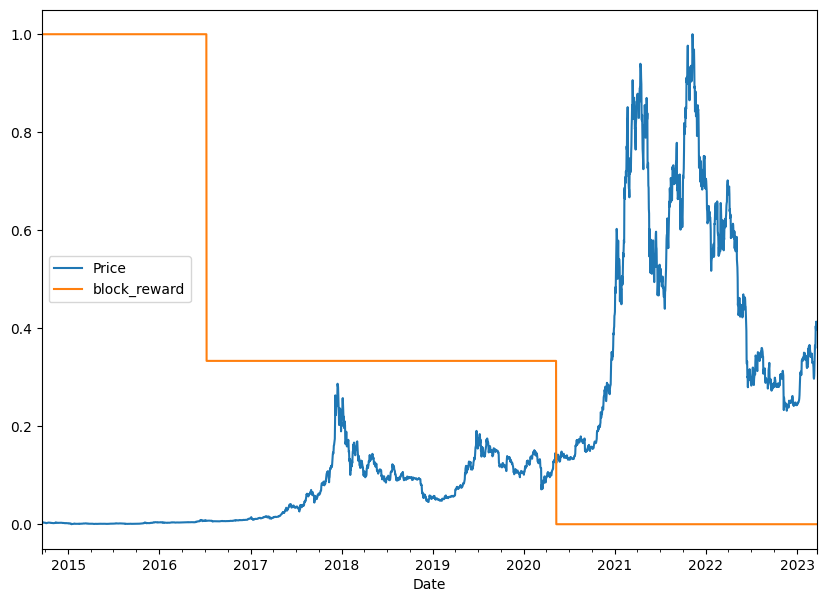

In [93]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

In the above plot when we set the same scale for prices and block reward, we can see the Prices go up when block reward get reduced.

## Making a windowed dataset with pandas

Previously we created some custom function to window our univariate time series.

Since we have added one more variable to our dataset, these functions won't work.

In pandas, there is a function called [`.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html), which can be used to create windows on multivariate time series dataset.


In [94]:
# Setup dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [95]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)               

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


Alright, we need to drop NaNs and make feature set and label set.

In [96]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

# Make train test split
split_size = int(len(X) * 0.8) # 80%
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

X_train.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [97]:
X_train.shape, X_test.shape

((2480, 8), (621, 8))

## Model 6 : Multivariate Time Series (Dense model)

We're going to build the same model like `model_1` architecture and use it to train and make predictions on our multivariate time series data.

In [98]:
tf.random.set_seed(17)

# Create the model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], "model_6_multivariate_dense")

# Compile the model
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit the model
model_6.fit(X_train,
            y_train,
            epochs=100,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name="model_6_multivariate_dense")])

Epoch 1/100
18/20 [==========================>...] - ETA: 0s - loss: 4097.8628 

20/20 [==============================] - 3s 115ms/step - loss: 3848.0144 - val_loss: 4615.0850
Epoch 2/100
18/20 [==========================>...] - ETA: 0s - loss: 820.8724

20/20 [==============================] - 1s 72ms/step - loss: 802.8719 - val_loss: 1701.9885
Epoch 3/100
15/20 [=====================>........] - ETA: 0s - loss: 503.7306

20/20 [==============================] - 1s 51ms/step - loss: 495.3041 - val_loss: 1419.1537
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 443.8082 - val_loss: 1519.3833
Epoch 5/100
 9/20 [============>.................] - ETA: 0s - loss: 423.7081

20/20 [==============================] - 1s 43ms/step - loss: 429.1274 - val_loss: 1319.8228
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 407.2101 - val_loss: 1387.2004
Epoch 7/100
19/20 [===========================>..] - ETA: 0s - loss: 394.1422

20/20 [==============================] - 1s 42ms/step - loss: 396.3368 - val_loss: 1261.8890
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 408.8563

20/20 [==============================] - 2s 99ms/step - loss: 410.4071 - val_loss: 1185.1677
Epoch 9/100
20/20 [==============================] - 0s 6ms/step - loss: 379.4572 - val_loss: 1292.6282
Epoch 10/100
14/20 [====================>.........] - ETA: 0s - loss: 361.1398

20/20 [==============================] - 1s 57ms/step - loss: 361.2930 - val_loss: 1139.8480
Epoch 11/100
20/20 [==============================] - 0s 9ms/step - loss: 350.2832 - val_loss: 1220.3871
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 348.7089

20/20 [==============================] - 1s 58ms/step - loss: 348.7089 - val_loss: 1115.6129
Epoch 13/100
 1/20 [>.............................] - ETA: 0s - loss: 395.7292

20/20 [==============================] - 2s 81ms/step - loss: 332.5150 - val_loss: 1052.5306
Epoch 14/100
20/20 [==============================] - 0s 8ms/step - loss: 321.2978 - val_loss: 1194.2748
Epoch 15/100
20/20 [==============================] - 0s 9ms/step - loss: 322.2711 - val_loss: 1123.1852
Epoch 16/100
16/20 [=======================>......] - ETA: 0s - loss: 336.5735

20/20 [==============================] - 2s 108ms/step - loss: 329.5664 - val_loss: 1002.8156
Epoch 17/100
20/20 [==============================] - 0s 12ms/step - loss: 322.2817 - val_loss: 1258.8427
Epoch 18/100
20/20 [==============================] - 0s 15ms/step - loss: 304.6106 - val_loss: 1100.3328
Epoch 19/100
20/20 [==============================] - 0s 11ms/step - loss: 311.9044 - val_loss: 1306.9357
Epoch 20/100
20/20 [==============================] - 0s 10ms/step - loss: 328.3901 - val_loss: 1118.4315
Epoch 21/100
14/20 [====================>.........] - ETA: 0s - loss: 307.4090

20/20 [==============================] - 1s 78ms/step - loss: 299.8586 - val_loss: 1002.2450
Epoch 22/100
14/20 [====================>.........] - ETA: 0s - loss: 302.3653

20/20 [==============================] - 1s 58ms/step - loss: 304.4804 - val_loss: 999.3857
Epoch 23/100
20/20 [==============================] - 0s 8ms/step - loss: 300.4542 - val_loss: 1329.6985
Epoch 24/100
20/20 [==============================] - 0s 8ms/step - loss: 324.6310 - val_loss: 1250.1317
Epoch 25/100
17/20 [========================>.....] - ETA: 0s - loss: 299.7690

20/20 [==============================] - 1s 47ms/step - loss: 294.4164 - val_loss: 989.4671
Epoch 26/100
 1/20 [>.............................] - ETA: 0s - loss: 265.5884

20/20 [==============================] - 1s 50ms/step - loss: 286.6237 - val_loss: 971.5247
Epoch 27/100
20/20 [==============================] - 0s 4ms/step - loss: 292.4726 - val_loss: 1031.7129
Epoch 28/100
 1/20 [>.............................] - ETA: 0s - loss: 268.9649

20/20 [==============================] - 1s 47ms/step - loss: 286.4341 - val_loss: 965.8735
Epoch 29/100
10/20 [==============>...............] - ETA: 0s - loss: 296.8938

20/20 [==============================] - 1s 55ms/step - loss: 286.1767 - val_loss: 923.1993
Epoch 30/100
17/20 [========================>.....] - ETA: 0s - loss: 284.1971

20/20 [==============================] - 1s 40ms/step - loss: 284.7683 - val_loss: 919.2413
Epoch 31/100
20/20 [==============================] - 0s 8ms/step - loss: 282.4720 - val_loss: 921.6622
Epoch 32/100
20/20 [==============================] - 0s 10ms/step - loss: 277.4933 - val_loss: 968.1529
Epoch 33/100
20/20 [==============================] - 0s 7ms/step - loss: 290.9653 - val_loss: 1066.8771
Epoch 34/100
20/20 [==============================] - 0s 6ms/step - loss: 278.9351 - val_loss: 987.8104
Epoch 35/100
17/20 [========================>.....] - ETA: 0s - loss: 275.0557

20/20 [==============================] - 1s 61ms/step - loss: 281.9075 - val_loss: 902.9389
Epoch 36/100
20/20 [==============================] - 0s 8ms/step - loss: 277.7889 - val_loss: 1071.0143
Epoch 37/100
20/20 [==============================] - 0s 6ms/step - loss: 283.4207 - val_loss: 942.3364
Epoch 38/100
20/20 [==============================] - 0s 9ms/step - loss: 278.5138 - val_loss: 903.1901
Epoch 39/100
17/20 [========================>.....] - ETA: 0s - loss: 274.7654

20/20 [==============================] - 2s 96ms/step - loss: 275.1901 - val_loss: 897.6183
Epoch 40/100
20/20 [==============================] - 0s 10ms/step - loss: 308.5302 - val_loss: 1432.9773
Epoch 41/100
20/20 [==============================] - 0s 12ms/step - loss: 328.6651 - val_loss: 1263.6189
Epoch 42/100
20/20 [==============================] - 0s 13ms/step - loss: 288.7797 - val_loss: 980.9857
Epoch 43/100
12/20 [=================>............] - ETA: 0s - loss: 260.9531

20/20 [==============================] - 1s 62ms/step - loss: 274.2856 - val_loss: 884.2542
Epoch 44/100
20/20 [==============================] - 0s 8ms/step - loss: 268.5718 - val_loss: 946.7380
Epoch 45/100
18/20 [==========================>...] - ETA: 0s - loss: 286.2192

20/20 [==============================] - 1s 45ms/step - loss: 279.5836 - val_loss: 879.9009
Epoch 46/100
20/20 [==============================] - 0s 5ms/step - loss: 281.9545 - val_loss: 1042.8428
Epoch 47/100
20/20 [==============================] - 0s 4ms/step - loss: 273.5758 - val_loss: 882.2684
Epoch 48/100
 1/20 [>.............................] - ETA: 0s - loss: 259.3293

20/20 [==============================] - 1s 50ms/step - loss: 263.3859 - val_loss: 873.3919
Epoch 49/100
20/20 [==============================] - 0s 7ms/step - loss: 270.9826 - val_loss: 898.5504
Epoch 50/100
20/20 [==============================] - 0s 7ms/step - loss: 264.4380 - val_loss: 876.2599
Epoch 51/100
20/20 [==============================] - 0s 8ms/step - loss: 263.6429 - val_loss: 998.1295
Epoch 52/100
17/20 [========================>.....] - ETA: 0s - loss: 264.2743

20/20 [==============================] - 1s 56ms/step - loss: 263.2729 - val_loss: 867.2452
Epoch 53/100
20/20 [==============================] - 0s 6ms/step - loss: 262.8555 - val_loss: 1006.8911
Epoch 54/100
 1/20 [>.............................] - ETA: 0s - loss: 218.1324

20/20 [==============================] - 1s 42ms/step - loss: 276.6001 - val_loss: 866.5958
Epoch 55/100
20/20 [==============================] - 0s 7ms/step - loss: 270.4225 - val_loss: 1209.0491
Epoch 56/100
18/20 [==========================>...] - ETA: 0s - loss: 281.5925

20/20 [==============================] - 1s 65ms/step - loss: 274.4026 - val_loss: 863.4899
Epoch 57/100
16/20 [=======================>......] - ETA: 0s - loss: 270.1562

20/20 [==============================] - 2s 84ms/step - loss: 268.1807 - val_loss: 859.9557
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 258.8835 - val_loss: 937.8405
Epoch 59/100
20/20 [==============================] - 0s 5ms/step - loss: 275.2712 - val_loss: 929.8652
Epoch 60/100
17/20 [========================>.....] - ETA: 0s - loss: 264.4492

20/20 [==============================] - 2s 88ms/step - loss: 264.5777 - val_loss: 848.7855
Epoch 61/100
20/20 [==============================] - 1s 33ms/step - loss: 276.0661 - val_loss: 1026.8639
Epoch 62/100
20/20 [==============================] - 1s 28ms/step - loss: 278.2245 - val_loss: 855.6335
Epoch 63/100
20/20 [==============================] - 0s 11ms/step - loss: 261.5776 - val_loss: 910.7714
Epoch 64/100
20/20 [==============================] - 0s 6ms/step - loss: 280.2411 - val_loss: 1052.9957
Epoch 65/100
20/20 [==============================] - 0s 14ms/step - loss: 275.6741 - val_loss: 1005.0535
Epoch 66/100
20/20 [==============================] - 0s 6ms/step - loss: 298.0656 - val_loss: 1095.7599
Epoch 67/100
20/20 [==============================] - 0s 6ms/step - loss: 301.1717 - val_loss: 1164.6074
Epoch 68/100
20/20 [==============================] - 0s 7ms/step - loss: 305.2046 - val_loss: 1133.9773
Epoch 69/100
20/20 [==============================] - 0s 16ms/step

20/20 [==============================] - 1s 48ms/step - loss: 273.6656 - val_loss: 843.4525
Epoch 72/100
20/20 [==============================] - 0s 11ms/step - loss: 253.4378 - val_loss: 976.3102
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 268.7543 - val_loss: 853.4090
Epoch 74/100
 1/20 [>.............................] - ETA: 0s - loss: 316.4945

20/20 [==============================] - 1s 45ms/step - loss: 254.5902 - val_loss: 843.0199
Epoch 75/100
20/20 [==============================] - ETA: 0s - loss: 257.6116

20/20 [==============================] - 2s 95ms/step - loss: 257.6116 - val_loss: 835.2797
Epoch 76/100
20/20 [==============================] - 0s 24ms/step - loss: 260.8616 - val_loss: 879.6346
Epoch 77/100
20/20 [==============================] - 0s 12ms/step - loss: 255.4407 - val_loss: 866.8193
Epoch 78/100
20/20 [==============================] - 0s 10ms/step - loss: 266.5610 - val_loss: 860.6887
Epoch 79/100
19/20 [===========================>..] - ETA: 0s - loss: 255.9289

20/20 [==============================] - 1s 78ms/step - loss: 253.8549 - val_loss: 834.8552
Epoch 80/100
20/20 [==============================] - 0s 18ms/step - loss: 256.0257 - val_loss: 902.7994
Epoch 81/100
20/20 [==============================] - ETA: 0s - loss: 253.3222

20/20 [==============================] - 2s 117ms/step - loss: 253.3222 - val_loss: 832.0948
Epoch 82/100
20/20 [==============================] - 0s 15ms/step - loss: 284.1469 - val_loss: 1392.1270
Epoch 83/100
20/20 [==============================] - 0s 13ms/step - loss: 280.4555 - val_loss: 981.4492
Epoch 84/100
20/20 [==============================] - 1s 56ms/step - loss: 299.3286 - val_loss: 931.2032
Epoch 85/100
20/20 [==============================] - 1s 28ms/step - loss: 279.0450 - val_loss: 846.9012
Epoch 86/100
20/20 [==============================] - 1s 50ms/step - loss: 258.9892 - val_loss: 898.0762
Epoch 87/100
20/20 [==============================] - ETA: 0s - loss: 263.0396

20/20 [==============================] - 3s 180ms/step - loss: 263.0396 - val_loss: 829.2987
Epoch 88/100
20/20 [==============================] - 0s 10ms/step - loss: 250.6004 - val_loss: 863.8755
Epoch 89/100
20/20 [==============================] - 0s 8ms/step - loss: 259.8542 - val_loss: 832.2459
Epoch 90/100
20/20 [==============================] - 0s 7ms/step - loss: 250.3781 - val_loss: 881.0455
Epoch 91/100
20/20 [==============================] - 0s 9ms/step - loss: 251.2206 - val_loss: 829.3751
Epoch 92/100
20/20 [==============================] - 0s 10ms/step - loss: 252.3578 - val_loss: 840.5017
Epoch 93/100
20/20 [==============================] - 0s 8ms/step - loss: 256.1714 - val_loss: 829.5302
Epoch 94/100
20/20 [==============================] - 0s 7ms/step - loss: 258.6114 - val_loss: 1143.9205
Epoch 95/100
20/20 [==============================] - 0s 8ms/step - loss: 288.9193 - val_loss: 862.9619
Epoch 96/100
20/20 [==============================] - 0s 7ms/step - loss

In [99]:
# evaluate on last epoch
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 929.9600


929.9599609375

In [100]:
# load the best model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_multivariate_dense/")
model_6.evaluate(X_test, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 829.2987


829.2987060546875

In [101]:
# Make prediction
model_6_preds = make_predictions(model_6, X_test)

model_6_preds[:2]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([33085.215, 33494.28 ], dtype=float32)>

In [102]:
# evaluate preds
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 829.2987,
 'mse': 1557531.9,
 'rmse': 1248.0111,
 'mape': 2.4028301,
 'mase': 1.0000142}

In [103]:
model_1_results

{'mae': 833.2969,
 'mse': 1543701.0,
 'rmse': 1242.4576,
 'mape': 2.4049375,
 'mase': 1.0000142}

Oh great, we got the almost the same results as `model_1` but still `naive forecast` is the best so far.

In [104]:
naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

## Model 7 : N-BEATS Algorithm

So far we've tried on smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Bases Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state of the art performance in the winner of the M4 competition (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm ([section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))



### Building and Testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

In [105]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each ReLu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [106]:
# set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [107]:
# create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [108]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.63157517 -0.38162908  0.1757799   0.08988392  0.6760771   0.13114655
  0.18734905]
Forecast: -0.16233372688293457
